Remove duplicates

In [ ]:
import geopandas as gpd

# --- Load data ---
gdf = gpd.read_file("/content/drive/MyDrive/data_set/merge/clean/feature_extraction/data_final.gpkg")


# Columns to group by (ignore fire and geometry)
group_cols = gdf.columns.difference(['fire', 'geometry'])

# Aggregate duplicates
gdf_clean = (
    gdf
    .groupby(list(group_cols), as_index=False)  # group by all features except fire & geometry
    .agg({'fire': 'max', 'geometry': 'first'})  # keep fire=1 if any, else 0; keep first geometry
)

# Print number of rows before and after
print("Total rows before resolving duplicates:", len(gdf))
print("Total rows after resolving duplicates:", len(gdf_clean))

# Replace original gdf
gdf = gdf_clean

import geopandas as gpd

# Convert back to GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs="EPSG:4326")  # use your actual CRS

# Save to GPKG
output_path = "/content/drive/MyDrive/training_fire/Decision Tree/data_final.gpkg"
gdf.to_file(output_path, driver="GPKG")


Total rows before resolving duplicates: 12248
Total rows after resolving duplicates: 11829


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(gdf.columns)

Index(['ALUM_SAT', 'CLAY', 'ELEC_COND', 'GRIDCODE', 'ORG_CARBON', 'PH_WATER',
       'SAND', 'SILT', 'TEB', 'TOTAL_N', 'aspect1', 'elevation1', 'ndvi1',
       'precip_s1_log10', 'precip_s2_log10', 'precip_s3_log10',
       'precip_s4_log10', 'tmax_s1', 'tmax_s2', 'tmin_s1', 'tmin_s2', 'fire',
       'geometry'],
      dtype='object')


#From scratch

Accuracy: 0.8368554522400676
Precision: 0.64
Recall: 0.6083650190114068
F1 Score: 0.6237816764132553

Classification Report:
               precision    recall  f1-score   support

       False       0.89      0.90      0.90      1840
        True       0.64      0.61      0.62       526

    accuracy                           0.84      2366
   macro avg       0.76      0.76      0.76      2366
weighted avg       0.83      0.84      0.84      2366



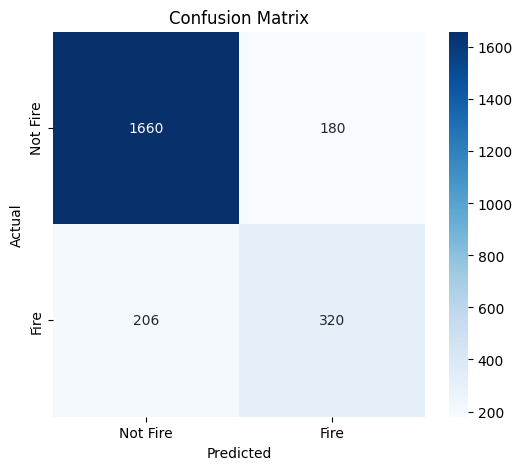

In [ ]:
  import pandas as pd
  import numpy as np
  from sklearn.model_selection import train_test_split
  from sklearn.preprocessing import OneHotEncoder
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
  import seaborn as sns
  import matplotlib.pyplot as plt

  # --- Features and target ---
  features = [
      'ALUM_SAT', 'CLAY', 'ELEC_COND', 'GRIDCODE', 'ORG_CARBON', 'PH_WATER',
      'SAND', 'SILT', 'TEB', 'TOTAL_N', 'aspect1', 'elevation1', 'ndvi1',
      'precip_s1_log10', 'precip_s2_log10', 'precip_s3_log10',
      'precip_s4_log10', 'tmax_s1', 'tmax_s2', 'tmin_s1', 'tmin_s2'
  ]
  target = 'fire'

  # --- Split data ---
  X = gdf[features].copy()
  y = gdf[target]

  # ---------------------------
  # One-hot encode GRIDCODE
  # ---------------------------
  X = pd.get_dummies(X, columns=['GRIDCODE'])



  # Train/test split
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  # --- ID3 implementation ---
  class TreeNode:

      # NODE
      def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
          self.feature = feature # node feature
          self.threshold = threshold #split value
          self.left = left    # each feature is split into 2 : save left and right tree
          self.right = right
          self.value = value  # for leaf (class value)

  def entropy(y):
      probs = y.value_counts(normalize=True)
      return -sum(p * np.log2(p) for p in probs if p > 0)

  def best_split(X, y):
      best_gain = -1
      best_feat, best_thresh = None, None
      base_entropy = entropy(y)

      # FOR EVERY FEATURE FIND BEST TRESHOLD FOR SPLITTING
      for feat in X.columns:

          # ORDER , UNIQUE
          values = X[feat].values
          if len(np.unique(values)) == 1:
              continue


          # FIND MIDPOINTS
          sorted_vals = np.unique(values)
          thresholds = (sorted_vals[:-1] + sorted_vals[1:]) / 2

          for thresh in thresholds:
              left_idx = values <= thresh
              right_idx = values > thresh

              if left_idx.sum() == 0 or right_idx.sum() == 0:   # PUREEEE
                  continue
              left_entropy = entropy(y[left_idx])
              right_entropy = entropy(y[right_idx])
              gain = base_entropy - (len(y[left_idx])/len(y))*left_entropy - (len(y[right_idx])/len(y))*right_entropy
              if gain > best_gain:
                  best_gain = gain
                  best_feat = feat
                  best_thresh = thresh

      return best_feat, best_thresh, best_gain

  def build_tree(X, y, depth=0, max_depth=15):
      # PURE LEAF
      if len(y.unique()) == 1:
          return TreeNode(value=y.iloc[0])
      # if max depth choose max class
      if depth >= max_depth or len(X) == 0:
          return TreeNode(value=y.mode()[0])

      feat, thresh, gain = best_split(X, y)
      if gain == -1:
          return TreeNode(value=y.mode()[0])

      left_idx = X[feat] <= thresh
      right_idx = X[feat] > thresh
      left = build_tree(X[left_idx], y[left_idx], depth+1, max_depth)
      right = build_tree(X[right_idx], y[right_idx], depth+1, max_depth)
      return TreeNode(feature=feat, threshold=thresh, left=left, right=right)

  def predict_tree(node, x):
      while node.value is None:
          if x[node.feature] <= node.threshold:
              node = node.left
          else:
              node = node.right
      return node.value

  # --- Train the tree ---
  tree = build_tree(X_train, y_train, max_depth=15)

  # --- Predict ---
  y_pred = X_test.apply(lambda row: predict_tree(tree, row), axis=1)

  # --- Metrics ---
  metrics = {
      "Accuracy": accuracy_score(y_test, y_pred),
      "Precision": precision_score(y_test, y_pred),
      "Recall": recall_score(y_test, y_pred),
      "F1 Score": f1_score(y_test, y_pred)
  }
  for k, v in metrics.items():
      print(f"{k}: {v}")

  print("\nClassification Report:\n", classification_report(y_test, y_pred))

  conf_matrix = confusion_matrix(y_test, y_pred)
  labels = ['Not Fire', 'Fire']

  plt.figure(figsize=(6,5))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()


# Scikit learn

Best max_depth: 15
Best CV F1 score: 0.6177023876578495
Accuracy: 0.830938292476754
Precision: 0.6317991631799164
Recall: 0.5741444866920152
F1 Score: 0.601593625498008

Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.90      0.89      1840
        True       0.63      0.57      0.60       526

    accuracy                           0.83      2366
   macro avg       0.76      0.74      0.75      2366
weighted avg       0.83      0.83      0.83      2366



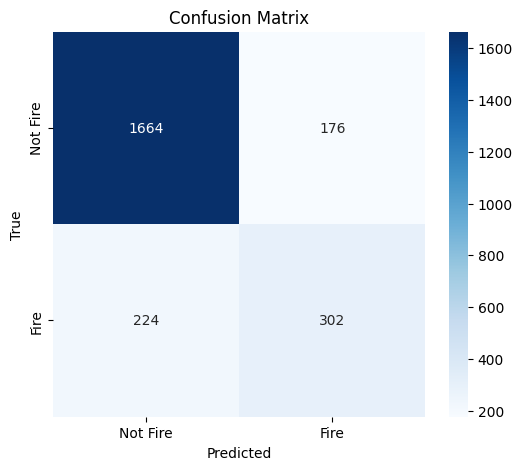

In [ ]:
import geopandas as gpd
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt


# Features and target
features = [
    'ALUM_SAT', 'CLAY', 'ELEC_COND', 'GRIDCODE', 'ORG_CARBON', 'PH_WATER',
    'SAND', 'SILT', 'TEB', 'TOTAL_N', 'aspect1', 'elevation1', 'ndvi1',
    'precip_s1_log10', 'precip_s2_log10', 'precip_s3_log10',
    'precip_s4_log10', 'tmax_s1', 'tmax_s2', 'tmin_s1', 'tmin_s2'
]
target = 'fire'

X = gdf[features].copy()
y = gdf[target]


# --------------------------
# ONE-HOT ENCODING for GRIDCODE
# --------------------------
X = pd.get_dummies(X, columns=['GRIDCODE'], drop_first=False)


# --------------------------
# TRAIN / TEST SPLIT
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# --------------------------
# GRID SEARCH FOR MAX DEPTH
# --------------------------
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None]
}

dt = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best CV F1 score:", grid_search.best_score_)


# --------------------------
# TRAIN BEST MODEL
# --------------------------
clf = grid_search.best_estimator_

clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)


# --------------------------
# METRICS
# --------------------------
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

for k, v in metrics.items():
    print(f"{k}: {v}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))


# --------------------------
# CONFUSION MATRIX
# --------------------------
conf_matrix = confusion_matrix(y_test, y_pred)

labels = ['Not Fire', 'Fire']

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# recall fire <<<<< many fire points predicted as not fire
# for not fire its ok --. model is biased towrds it cuz data is imbalanced
# basically its predicting everythin as not fire


#TOMEK

BAYNAAAAAAAAAAA MYMDOCHHHHHHHHH MALIHHHHHHHHH

Original distribution: {np.int64(0): np.int64(9200), np.int64(1): np.int64(2629)}
After Tomek Links: {np.int64(0): np.int64(8398), np.int64(1): np.int64(2629)}
Accuracy: 0.8409
Precision: 0.7040
Recall: 0.5741
F1 Score: 0.6325

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      1680
           1       0.70      0.57      0.63       526

    accuracy                           0.84      2206
   macro avg       0.79      0.75      0.77      2206
weighted avg       0.83      0.84      0.84      2206



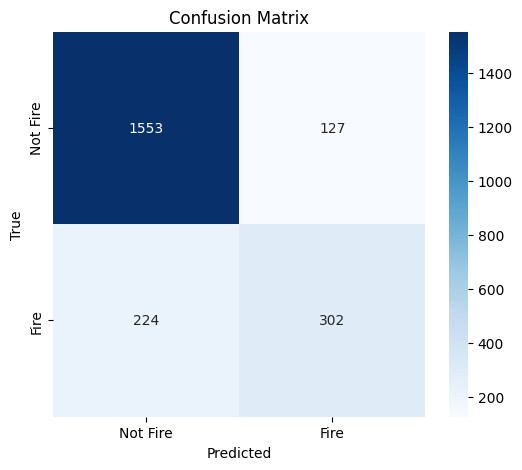

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.under_sampling import TomekLinks

# -----------------------------
# 1️⃣ Load dataset
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/Decision Tree/data_final.gpkg")
df = gdf.drop(columns="geometry")
df['fire'] = df['fire'].astype(int)

# -----------------------------
# 2️⃣ Features / target
# -----------------------------
X = df.drop(columns=['fire']).values
y = df['fire'].values

# -----------------------------
# 3️⃣ Original distribution
# -----------------------------
unique, counts = np.unique(y, return_counts=True)
print("Original distribution:", dict(zip(unique, counts)))

# -----------------------------
# 4️⃣ Apply Tomek Links
# -----------------------------
tl = TomekLinks(sampling_strategy='majority')  # removes majority samples near minority
X_res, y_res = tl.fit_resample(X, y)

unique_res, counts_res = np.unique(y_res, return_counts=True)
print("After Tomek Links:", dict(zip(unique_res, counts_res)))

# -----------------------------
# 5️⃣ Train / Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# -----------------------------
# 6️⃣ Decision Tree
# -----------------------------
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# -----------------------------
# 7️⃣ Metrics
# -----------------------------
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -----------------------------
# 8️⃣ Confusion Matrix
# -----------------------------
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['Not Fire', 'Fire']

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#AdaSYN + TOMEK

Original distribution: {np.int64(0): np.int64(9200), np.int64(1): np.int64(2629)}
After ADASYN (~40/60): {np.int64(0): np.int64(9200), np.int64(1): np.int64(5688)}
After TomekLinks: {np.int64(0): np.int64(8818), np.int64(1): np.int64(5688)}
Final distribution (~45/55): {np.int64(0): np.int64(7979), np.int64(1): np.int64(5688)}
Accuracy: 0.7634
Precision: 0.6850
Recall: 0.7988
F1 Score: 0.7375

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.78      1596
           1       0.69      0.80      0.74      1138

    accuracy                           0.76      2734
   macro avg       0.76      0.77      0.76      2734
weighted avg       0.77      0.76      0.76      2734



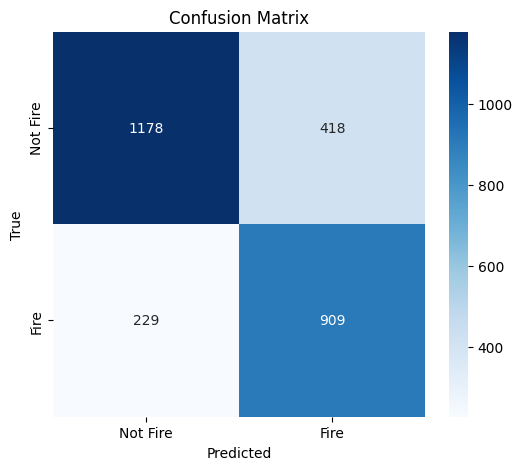

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.utils import resample

# -----------------------------
# 1️⃣ Load dataset
# -----------------------------
gdf = gpd.read_file("/content/drive/MyDrive/training_fire/Decision Tree/data_final.gpkg")
df = gdf.drop(columns="geometry")
df['fire'] = df['fire'].astype(int)

# -----------------------------
# 2️⃣ Features / target
# -----------------------------
X = df.drop(columns=['fire']).values
y = df['fire'].values

# -----------------------------
# 3️⃣ Check original distribution
# -----------------------------
unique, counts = np.unique(y, return_counts=True)
print("Original distribution:", dict(zip(unique, counts)))

# -----------------------------
# 4️⃣ Step 1: Oversample Fire to ~40% Fire / 60% Not Fire
# -----------------------------
N_fire_original = np.sum(y == 1)
N_notfire = np.sum(y == 0)
N_fire_target = int((40/60) * N_notfire)  # Fire count = 40/60 of Not Fire

adasyn = ADASYN(sampling_strategy={1: N_fire_target}, random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)

unique2, counts2 = np.unique(y_res, return_counts=True)
print("After ADASYN (~40/60):", dict(zip(unique2, counts2)))

# -----------------------------
# 5️⃣ Step 2: Tomek Links to clean / slightly undersample Not Fire
# -----------------------------
tl = TomekLinks(sampling_strategy='majority')
X_res2, y_res2 = tl.fit_resample(X_res, y_res)

unique3, counts3 = np.unique(y_res2, return_counts=True)
print("After TomekLinks:", dict(zip(unique3, counts3)))

# -----------------------------
# 6️⃣ Step 3: Adjust manually to ~45/55 Fire / Not Fire
# -----------------------------
total = sum(counts3)
target_fire = int(0.45 * total)
target_notfire = total - target_fire

X_fire_final = X_res2[y_res2 == 1]
y_fire_final = y_res2[y_res2 == 1]
X_notfire_final = X_res2[y_res2 == 0]
y_notfire_final = y_res2[y_res2 == 0]

# Undersample Not Fire if needed
if len(X_notfire_final) > target_notfire:
    X_notfire_final, y_notfire_final = resample(
        X_notfire_final, y_notfire_final,
        replace=False,
        n_samples=target_notfire,
        random_state=42
    )

# Merge final dataset
X_final = np.vstack((X_fire_final, X_notfire_final))
y_final = np.concatenate((y_fire_final, y_notfire_final))

# Shuffle final dataset
perm = np.random.RandomState(seed=42).permutation(len(y_final))
X_final = X_final[perm]
y_final = y_final[perm]

# Final distribution
unique_final, counts_final = np.unique(y_final, return_counts=True)
print("Final distribution (~45/55):", dict(zip(unique_final, counts_final)))

# -----------------------------
# 7️⃣ Train / Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# -----------------------------
# 8️⃣ Decision Tree
# -----------------------------
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# -----------------------------
# 9️⃣ Metrics
# -----------------------------
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -----------------------------
# 🔟 Confusion Matrix
# -----------------------------
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['Not Fire', 'Fire']

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
